# Exploração Numérica do Problema

Sumário  
Intro  
          --- Importação  
Exploração Numérica  
        ---Média, mediana e percentis  
        ---Média, mediana e percentis por classe  
        --- Gráficos  
Árvore de Decisão  
        ---Completa  
        ---Reduzida  

In [1]:
import pandas
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
import sklearn as skl

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from statistics import mean
from numpy.linalg import norm
from matplotlib.colors import ListedColormap
import random
import time
import timeit

In [2]:
#importação da base de dados
file = "covtype.data"

#nome dos atributos
#estamos descartando os atributos que descrevem o tipo do solo
names = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area_Rawah', 'Wilderness_Area_Neota', 'Wilderness_Area_Comanche', 'Wilderness_Area_Cache', 'Cover_Type']

#de 0 a 13 são os atributos listados acima, e 54 é a classificação
usecols = list(range(0, 14)) + [54]

#especifico o tipo de alguns parametros(os que não são simplesmente numéricos)
dtype = {'Cover_Type': 'category', 'Wilderness_Area_Rawah' : bool, 'Wilderness_Area_Neota' : bool, 'Wilderness_Area_Comanche' : bool, 'Wilderness_Area_Cache' : bool}

#lê o arquivo num pandas.dataframe
dataset = pandas.read_csv(file, header = None, usecols = usecols, names = names, dtype = dtype)

#adicionando uma coluna adicional para sintetizar os 4 boleanos que representam a Wilderness_area. 
#para uma única instância, somente um dos 4 booleanos pode ser verdadeiro, logo eles, em realidade, funcionam como uma categorização
new_column = pandas.Series([1 if dataset['Wilderness_Area_Rawah'][i] else 
                            2 if dataset['Wilderness_Area_Neota'][i] else
                            3 if dataset['Wilderness_Area_Comanche'][i] else
                            4 for i in range(len(dataset.index)) ], dtype="category")
#elimina as colunas reduzidas
dataset = dataset.drop(columns=['Wilderness_Area_Rawah', 'Wilderness_Area_Neota', 'Wilderness_Area_Comanche', 'Wilderness_Area_Cache'])
#insere nova coluna na posição 10
dataset.insert(loc = 10, column = 'Wilderness_Area', value = new_column)

#atualiza names para refletir a mudança acima
names = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area', 'Cover_Type']

print("Dataframe com %d exemplares e %d atributos importado com sucesso" % (dataset.values.shape[0], dataset.values.shape[1]))

Dataframe com 581012 exemplares e 12 atributos importado com sucesso


In [3]:
#corr = dataset.corr()['Cover_Type'][dataset.corr()['Cover_Type'] < 1].abs()
#corr.sort(ascending = False)
#corr.head()

In [4]:
#atributos importados e seus tipos de dados
print(dataset.dtypes)

Elevation                                int64
Aspect                                   int64
Slope                                    int64
Horizontal_Distance_To_Hydrology         int64
Vertical_Distance_To_Hydrology           int64
Horizontal_Distance_To_Roadways          int64
Hillshade_9am                            int64
Hillshade_Noon                           int64
Hillshade_3pm                            int64
Horizontal_Distance_To_Fire_Points       int64
Wilderness_Area                       category
Cover_Type                            category
dtype: object


In [5]:
#quantidade de exemplares por classificação
dataset.groupby('Cover_Type').size()

Cover_Type
1    211840
2    283301
3     35754
4      2747
5      9493
6     17367
7     20510
dtype: int64

In [6]:
#um exemplar da base de dados, para visualização
dataset.head(1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,5


In [7]:
#sumário dos dados, geral
dataset.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


In [8]:
#sumário dos dados, por classificação
gp = dataset.groupby('Cover_Type')
for name in names:
    print(name)
    display(gp[name].describe())

Elevation


,count,mean,std,min,25%,50%,75%,max
Cover_Type,,,,,,,,
1,211840.0,3128.644888,157.805543,2466.0,3033.00,3146.0,3235.0,3686.0
2,283301.0,2920.936061,186.579366,2142.0,2794.00,2935.0,3042.0,3433.0
3,35754.0,2394.509845,196.732427,1859.0,2260.25,2404.0,2549.0,2899.0
4,2747.0,2223.939934,102.524587,1988.0,2142.00,2231.0,2304.0,2526.0
5,9493.0,2787.417571,96.594047,2482.0,2732.00,2796.0,2857.0,3011.0
6,17367.0,2419.181897,188.762292,1863.0,2320.00,2428.0,2544.0,2900.0
7,20510.0,3361.928669,106.915301,2868.0,3299.25,3363.0,3409.0,3858.0


Aspect


,count,mean,std,min,25%,50%,75%,max
Cover_Type,,,,,,,,
1,211840.0,156.138227,116.677893,0.0,52.0,122.0,278.0,360.0
2,283301.0,152.060515,107.658352,0.0,60.0,127.0,241.0,360.0
3,35754.0,176.372490,107.582644,0.0,90.0,160.0,284.0,360.0
4,2747.0,137.139425,86.996931,0.0,83.5,119.0,159.0,359.0
5,9493.0,139.283051,91.568676,0.0,71.0,111.0,191.0,359.0
6,17367.0,180.539068,133.786561,0.0,43.0,173.0,319.0,360.0
7,20510.0,153.236226,110.648845,0.0,66.0,123.0,240.0,360.0


Slope


,count,mean,std,min,25%,50%,75%,max
Cover_Type,,,,,,,,
1,211840.0,13.127110,6.826445,0.0,8.0,12.0,17.0,56.0
2,283301.0,13.550499,7.096956,0.0,8.0,13.0,18.0,66.0
3,35754.0,20.770208,9.005553,0.0,14.0,21.0,27.0,50.0
4,2747.0,18.528941,9.347785,0.0,11.0,19.0,26.0,46.0
5,9493.0,16.641315,8.214169,0.0,10.0,16.0,22.0,51.0
6,17367.0,19.048886,7.953378,0.0,13.0,19.0,25.0,54.0
7,20510.0,14.255924,7.463676,0.0,9.0,13.0,18.0,51.0


Horizontal_Distance_To_Hydrology


,count,mean,std,min,25%,50%,75%,max
Cover_Type,,,,,,,,
1,211840.0,270.555245,216.732789,0.0,95.0,218.0,400.0,1200.0
2,283301.0,279.916442,210.346056,0.0,120.0,240.0,391.0,1397.0
3,35754.0,210.276473,142.194533,0.0,90.0,190.0,301.0,726.0
4,2747.0,106.934838,139.737181,0.0,0.0,30.0,192.0,551.0
5,9493.0,212.354893,179.444536,0.0,85.0,175.0,300.0,1100.0
6,17367.0,159.853458,124.488319,0.0,60.0,134.0,240.0,644.0
7,20510.0,356.994686,295.093262,0.0,120.0,283.0,525.0,1323.0


Vertical_Distance_To_Hydrology


,count,mean,std,min,25%,50%,75%,max
Cover_Type,,,,,,,,
1,211840.0,42.156939,56.628398,-156.0,4.0,24.0,62.0,431.0
2,283301.0,45.884219,57.487644,-173.0,8.0,30.0,66.0,601.0
3,35754.0,62.446915,58.911774,-134.0,18.0,50.0,95.0,312.0
4,2747.0,41.186749,59.052920,-25.0,0.0,6.0,72.0,270.0
5,9493.0,50.610344,57.827970,-134.0,6.0,35.0,81.0,265.0
6,17367.0,45.437439,46.987262,-126.0,8.0,34.0,73.0,288.0
7,20510.0,69.474305,79.882861,-84.0,8.0,43.0,107.0,412.0


Horizontal_Distance_To_Roadways


,count,mean,std,min,25%,50%,75%,max
Cover_Type,,,,,,,,
1,211840.0,2614.834517,1497.907501,0.0,1400.0,2389.0,3624.00,6632.0
2,283301.0,2429.530799,1618.718859,0.0,1138.0,2039.0,3408.00,7117.0
3,35754.0,943.940734,614.681991,0.0,458.0,853.0,1290.00,3436.0
4,2747.0,914.199490,366.290139,67.0,624.0,949.0,1218.00,1702.0
5,9493.0,1349.765722,1044.690988,30.0,459.0,1282.0,1956.00,5206.0
6,17367.0,1037.169805,570.571139,0.0,600.0,966.0,1392.00,3092.0
7,20510.0,2738.250463,1200.589081,451.0,1742.5,2654.0,3729.75,5463.0


Hillshade_9am


,count,mean,std,min,25%,50%,75%,max
Cover_Type,,,,,,,,
1,211840.0,211.998782,24.820904,0.0,199.0,216.0,230.0,254.0
2,283301.0,213.844423,24.923248,0.0,201.0,219.0,232.0,254.0
3,35754.0,201.918415,40.642543,46.0,173.0,213.0,236.0,254.0
4,2747.0,228.345832,24.142644,127.0,215.0,235.0,249.0,254.0
5,9493.0,223.474876,22.725392,126.0,211.0,228.0,241.0,254.0
6,17367.0,192.844302,33.601420,0.0,168.0,196.0,220.0,254.0
7,20510.0,216.967723,23.438283,80.0,202.0,221.0,234.0,254.0


Hillshade_Noon


,count,mean,std,min,25%,50%,75%,max
Cover_Type,,,,,,,,
1,211840.0,223.430211,18.159926,74.0,214.0,226.0,236.0,254.0
2,283301.0,225.326596,18.509548,0.0,215.0,227.0,239.0,254.0
3,35754.0,215.826537,27.905613,93.0,200.0,221.0,238.0,254.0
4,2747.0,216.997088,20.917345,137.0,204.0,220.0,231.0,254.0
5,9493.0,219.035816,24.913339,95.0,205.0,224.0,238.0,254.0
6,17367.0,209.827662,24.417547,90.0,196.0,213.0,227.0,254.0
7,20510.0,221.746026,20.000063,98.0,211.0,224.0,236.0,254.0


Hillshade_3pm


,count,mean,std,min,25%,50%,75%,max
Cover_Type,,,,,,,,
1,211840.0,143.875038,36.041583,0.0,121.0,144.0,168.0,254.0
2,283301.0,142.983466,36.223845,0.0,120.0,142.0,167.0,254.0
3,35754.0,140.367176,52.481434,0.0,104.0,142.0,181.0,251.0
4,2747.0,111.392792,49.264367,0.0,74.0,113.0,149.0,232.0
5,9493.0,121.920889,49.400832,0.0,85.0,128.0,157.0,236.0
6,17367.0,148.284044,45.384632,0.0,116.0,150.0,184.0,248.0
7,20510.0,134.932033,38.937654,0.0,113.0,140.0,161.0,229.0


Horizontal_Distance_To_Fire_Points


,count,mean,std,min,25%,50%,75%,max
Cover_Type,,,,,,,,
1,211840.0,2009.253517,1234.823898,0.0,1100.0,1825.0,2642.0,7118.0
2,283301.0,2168.154849,1424.315110,0.0,1173.0,1846.0,2656.0,7173.0
3,35754.0,910.955949,527.109484,0.0,513.0,824.0,1201.0,2888.0
4,2747.0,859.124135,480.861801,0.0,466.0,806.0,1248.0,1921.0
5,9493.0,1577.719794,995.611463,42.0,902.0,1471.0,1981.0,6321.0
6,17367.0,1055.351471,576.374422,0.0,642.0,942.0,1359.0,2940.0
7,20510.0,2070.031594,1087.258556,0.0,1191.0,1969.0,2854.0,4589.0


Wilderness_Area


,count,unique,top,freq
Cover_Type,,,,
1,211840,3,1,105717
2,283301,4,1,146197
3,35754,2,4,21454
4,2747,1,4,2747
5,9493,2,3,5712
6,17367,2,4,9741
7,20510,3,3,13105


Cover_Type


,count,unique,top,freq
Cover_Type,,,,
1,211840,1,1,211840
2,283301,1,2,283301
3,35754,1,3,35754
4,2747,1,4,2747
5,9493,1,5,9493
6,17367,1,6,17367
7,20510,1,7,20510


In [9]:
#faz um histograma do atributo:
def histogram(att_name):
    
    fig, ax = plt.subplots()
    dataset[att_name].hist()
    ax.set(xlabel=att_name, ylabel = 'Number of Samples', title=att_name + ' Histogram')
    plt.show()

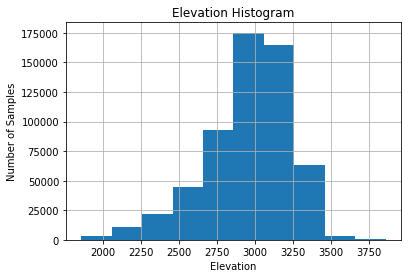

In [10]:
histogram('Elevation')

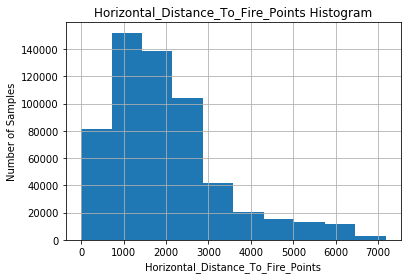

In [11]:
#um histograma da distância até foco de incêndio, que se provou um importante atributo
histogram('Horizontal_Distance_To_Fire_Points')

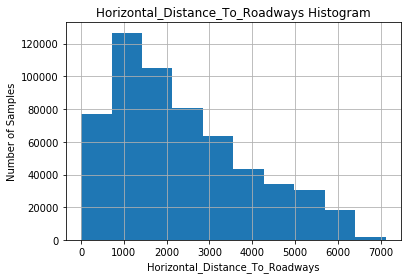

In [12]:
#um histograma da distância até rodovias, que se provou um importante atributo
histogram('Horizontal_Distance_To_Roadways')

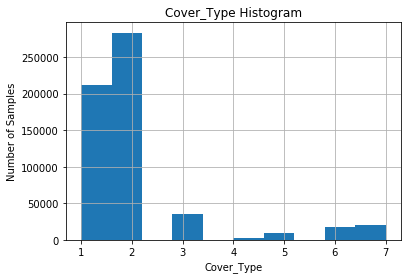

In [13]:
#um histograma distribuição entre as categorias de cobertura
histogram('Cover_Type')

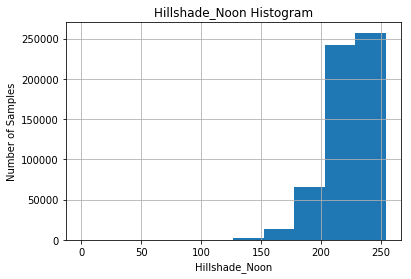

In [14]:
#um histograma distribuição do sombreamento ao meio dia, que não ajuda muito
histogram('Hillshade_Noon')

In [15]:

#faz um scatter plot maneiro
seed = 7
N = 250
#markerTypes = {'1':'.', '2': 'x', '3': 'o', '4': '^', '5': '1', '6': '2', '7': '3'}
markerTypes = {'1':'.', '2': '.', '3': '.', '4': '.', '5': '.', '6': '.', '7': '.'}
points = []
markers = []
gp = dataset.groupby('Cover_Type', sort = False)
samples_stratified = gp.apply(lambda x: x.sample(n = N, random_state = seed))
#para cada classificação, seleciona N amostras aleatórias pra serem plotadas

gp_random = dataset
samples_random = gp_random.apply(lambda x: x.sample(n = 7*N, random_state = seed))

#plota grafico name1 x name2
def scatter_plot(name1, name2, stratified = True):
    title_name = name1 + ' x ' + name2 + (' (E)' if stratified else ' (A)')
    samples = samples_stratified if stratified else samples_random
    fig, ax = plt.subplots()
    for cover_type, group in samples.groupby('Cover_Type'):

        plt.scatter(group[name1], group[name2], marker = markerTypes[cover_type])

    ax.set(xlabel=name1, ylabel=name2,
           title=title_name)
    plt.show()

C:\Users\Andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'Cover_Type' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


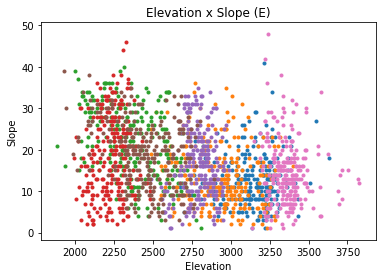

In [16]:
#plota grafico Elevation x Slope
scatter_plot('Elevation', 'Slope', stratified = True)


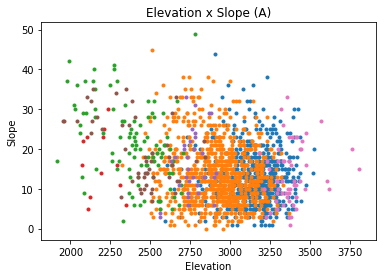

In [17]:
#plota grafico Elevation x Slope
scatter_plot('Elevation', 'Slope', stratified = False)

C:\Users\Andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'Cover_Type' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


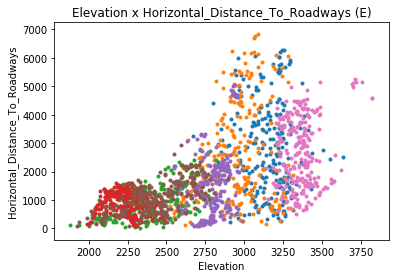

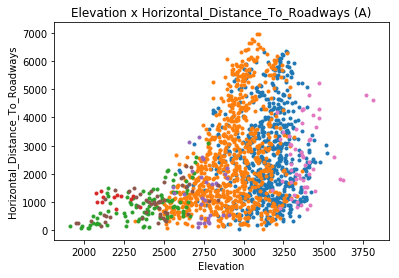

In [18]:
#plota grafico Elevation x Slope
scatter_plot('Elevation', 'Horizontal_Distance_To_Roadways', stratified = True)

#plota grafico Elevation x Slope
scatter_plot('Elevation', 'Horizontal_Distance_To_Roadways', stratified = False)


C:\Users\Andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'Cover_Type' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


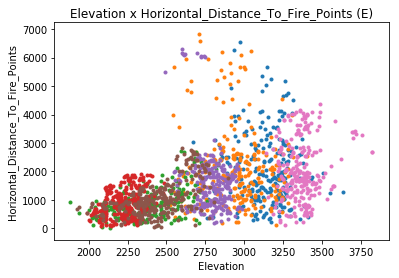

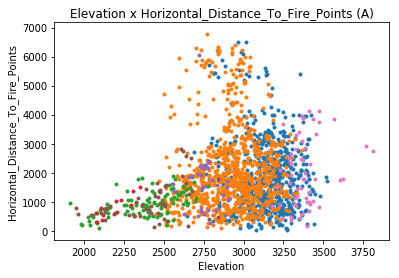

In [19]:
#plota grafico Elevation x Slope
scatter_plot('Elevation', 'Horizontal_Distance_To_Fire_Points', stratified = True)

#plota grafico Elevation x Slope
scatter_plot('Elevation', 'Horizontal_Distance_To_Fire_Points', stratified = False)

C:\Users\Andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'Cover_Type' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


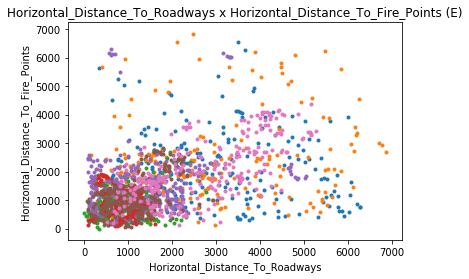

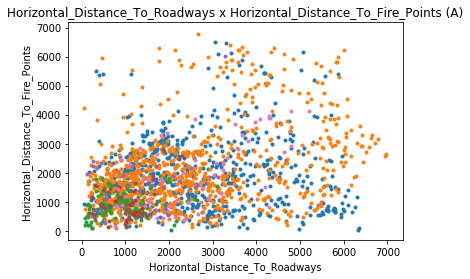

In [20]:
#plota grafico Elevation x Slope
scatter_plot('Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', stratified = True)

#plota grafico Elevation x Slope
scatter_plot('Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', stratified = False)

C:\Users\Andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'Cover_Type' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


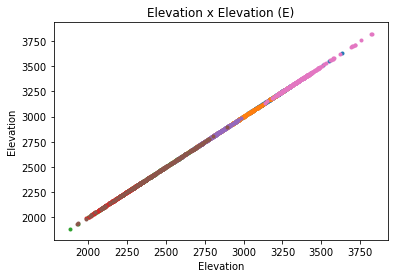

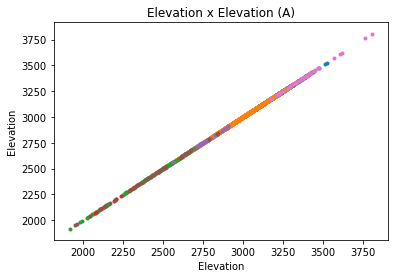

In [21]:
#plota grafico Elevation x Slope
scatter_plot('Elevation', 'Elevation', stratified = True)

#plota grafico Elevation x Slope
scatter_plot('Elevation', 'Elevation', stratified = False)

C:\Users\Andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'Cover_Type' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


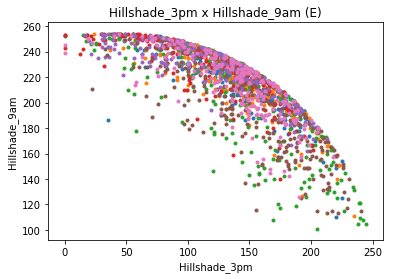

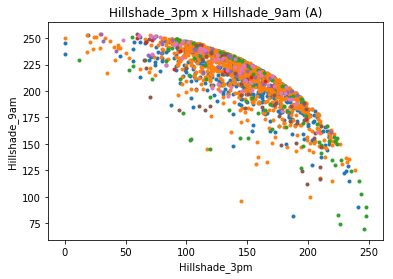

In [22]:
#plota grafico Elevation x Slope
scatter_plot('Hillshade_3pm', 'Hillshade_9am', stratified = True)

#plota grafico Elevation x Slope
scatter_plot('Hillshade_3pm', 'Hillshade_9am', stratified = False)

C:\Users\Andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'Cover_Type' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


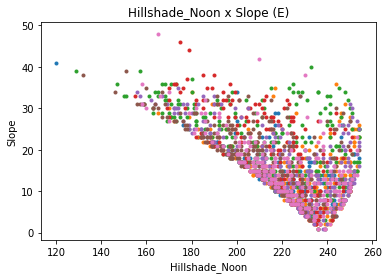

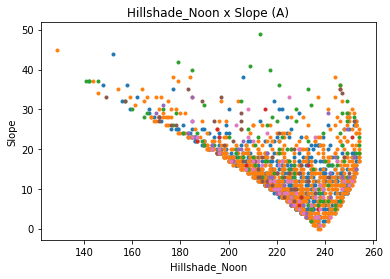

In [23]:
#plota grafico Elevation x Slope
scatter_plot('Hillshade_Noon', 'Slope', stratified = True)

#plota grafico Elevation x Slope
scatter_plot('Hillshade_Noon', 'Slope', stratified = False)

C:\Users\Andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'Cover_Type' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


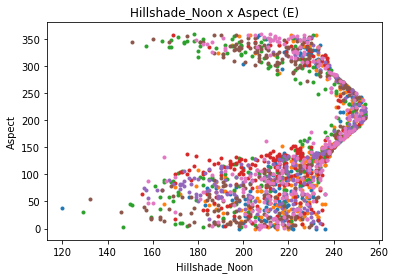

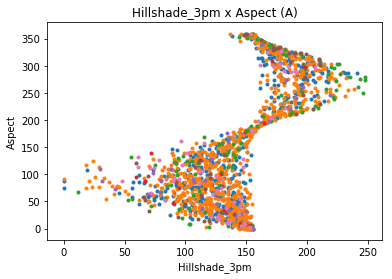

In [24]:
#plota grafico Elevation x Slope
scatter_plot('Hillshade_Noon', 'Aspect', stratified = True)

#plota grafico Elevation x Slope
scatter_plot('Hillshade_3pm', 'Aspect', stratified = False)

# Árvore de Decisão

In [25]:
#algumas funções auxiliares
def print_feature_importances(dtc):
    fi = dtc.feature_importances_
    for i in range(len(fi)):
        msg = "%s: %f" % (names[i], fi[i])
        print(msg)
       
def print_decision_tree_info(estimator, verbose = False):
    
    print(type(estimator))
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    if(verbose): print("The binary tree structure has %s nodes and has "
          "the following tree structure:"
          % n_nodes)
    for i in range(n_nodes):
        if is_leaves[i]:
            if(verbose): print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
        else:
            if (verbose):print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
                  "node %s."
                  % (node_depth[i] * "\t",
                     i,
                     children_left[i],
                     feature[i],
                     threshold[i],
                     children_right[i],
                     ))
    print()
    
    print("Node count:", n_nodes)
    print("Leaf node count:", sum(b for b in is_leaves))
    print("Max node depth:", node_depth.max())
    
def get_decision_tree_info(estimator, verbose = False):
    
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    if(verbose): print("The binary tree structure has %s nodes and has "
          "the following tree structure:"
          % n_nodes)
    for i in range(n_nodes):
        if is_leaves[i]:
            if(verbose): print("%snode=%s leaf node." % (node_depth[i] * "\t", i))
        else:
            if (verbose):print("%snode=%s test node: go to node %s if X[:, %s] <= %s else to "
                  "node %s."
                  % (node_depth[i] * "\t",
                     i,
                     children_left[i],
                     feature[i],
                     threshold[i],
                     children_right[i],
                     ))
    print()
    
    return (n_nodes, sum(b for b in is_leaves), node_depth.max())

In [26]:
array = dataset.values
X = array[:, 0:11]
Y = array[:, 11]

#preprocessa dataset
#estava preprocessando, mas não fazia diferença
#X_scale_temp = preprocessing.scale(X[:, 0:10])
#X_scaled = np.append(X_scale_temp, X[:, 10].reshape(-1, 1), axis = 1)


validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size = validation_size, random_state = seed)

In [27]:
scoring = 'accuracy'
seed = 7
def EstimarAcuraciaMetodo(metodo, k = 10):
    kfold = model_selection.KFold(n_splits = k, shuffle = True, random_state = 121)#, random_state = seed)
    cv_results = model_selection.cross_validate(metodo, X_train, Y_train, cv = kfold, scoring = scoring, return_train_score = False)
    print(cv_results)
    msg = "%s média entre os %d folds: %f, com desvio padrão de %f ,em " % (scoring, k, cv_results['test_score'].mean(), cv_results['test_score'].std())
    print(msg)
    msg2 = "tempo médio de treino: %f, para %d samples por fit" % (cv_results['fit_time'].mean(), (len(X_train) // k) * (k-1))
    print(msg2)
    msg3 = "tempo médio de avaliação de uma sample: %f" % (cv_results['score_time'].mean() / ((len(X_train) / k)))
    print(msg3)

def EstimarAcuraciaMetodo_dtc(metodo, k = 10):
    kfold = model_selection.KFold(n_splits = k, shuffle = True, random_state = 121)#, random_state = seed)
    cv_results = model_selection.cross_validate(metodo, X_train, Y_train, cv = kfold, scoring = scoring, return_estimator=True)
    #print(cv_results)
    msg = "%s média entre os %d folds: %f, com desvio padrão de %f ,em " % (scoring, k, cv_results['test_score'].mean(), cv_results['test_score'].std())
    print(msg)
    msg2 = "tempo médio de treino: %f, para %d samples por fit" % (cv_results['fit_time'].mean(), (len(X_train) // k) * (k-1))
    print(msg2)
    nodes_n = []
    for dtc in cv_results['estimator']:
        nodes_n.append(get_decision_tree_info(dtc)[0])
    print("Média de %f nós por árvore gerada" % mean(nodes_n))
    print(nodes_n)

In [28]:
dtcN = DecisionTreeClassifier(random_state = seed)
EstimarAcuraciaMetodo_dtc(dtcN)

accuracy média entre os 10 folds: 0.922661, com desvio padrão de 0.001399 ,em 
tempo médio de treino: 6.513312, para 418320 samples por fit










Média de 52896.000000 nós por árvore gerada
[52857, 53283, 53079, 53393, 52847, 52277, 52979, 52787, 52531, 52927]


In [29]:
#experimetando com profundidades máximas. Já fiz a sem limite de profundidade aqui em cima
n_list = [1, 3, 5, 10,20, 30]
for i in n_list:
    print("Arvore de decisão limitada a profundidade de %d" % i)
    dtc1 = DecisionTreeClassifier(random_state = seed, max_depth = i)
    EstimarAcuraciaMetodo_dtc(dtc1)
    print(" ")

Arvore de decisão limitada a profundidade de 1
accuracy média entre os 10 folds: 0.633617, com desvio padrão de 0.001610 ,em 
tempo médio de treino: 1.318089, para 418320 samples por fit










Média de 3.000000 nós por árvore gerada
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
 
Arvore de decisão limitada a profundidade de 3
accuracy média entre os 10 folds: 0.674546, com desvio padrão de 0.001216 ,em 
tempo médio de treino: 1.936361, para 418320 samples por fit










Média de 15.000000 nós por árvore gerada
[15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
 
Arvore de decisão limitada a profundidade de 5
accuracy média entre os 10 folds: 0.692441, com desvio padrão de 0.001836 ,em 
tempo médio de treino: 2.624285, para 418320 samples por fit










Média de 63.000000 nós por árvore gerada
[63, 63, 63, 63, 63, 63, 63, 63, 63, 63]
 
Arvore de decisão limitada a profundidade de 10
accuracy média entre os 10 folds: 0.763163, com desvio padrão de 0.001660 ,em 
tempo médio de treino: 3.885199, para 418

In [30]:
#novamente árvore de decisão, porém reduzida a tres attributos
X_3 = np.zeros((array.shape[0], 3))
X_3[:, 0] = dataset['Elevation']
X_3[:, 1] = dataset['Horizontal_Distance_To_Roadways']
X_3[:, 2] = dataset['Horizontal_Distance_To_Fire_Points']
Y = dataset.values[:, 11]
validation_size = 0.2
seed = 7
X_train_3, X_validation_3, Y_train_3, Y_validation_3 = model_selection.train_test_split(X_3, Y, test_size = validation_size, random_state = seed)


In [31]:
def EstimarAcuraciaMetodo_dtc_3(metodo, k = 10):
    kfold = model_selection.KFold(n_splits = k, shuffle = True, random_state = 121)#, random_state = seed)
    cv_results = model_selection.cross_validate(metodo, X_train_3, Y_train_3, cv = kfold, scoring = scoring, return_estimator=True)
    #print(cv_results)
    msg = "%s média entre os %d folds: %f, com desvio padrão de %f ,em " % (scoring, k, cv_results['test_score'].mean(), cv_results['test_score'].std())
    print(msg)
    msg2 = "tempo médio de treino: %f, para %d samples por fit" % (cv_results['fit_time'].mean(), (len(X_train_3) // k) * (k-1))
    print(msg2)
    nodes_n = []
    for dtc in cv_results['estimator']:
        nodes_n.append(get_decision_tree_info(dtc)[0])
    print("Média de %f nós por árvore gerada" % mean(nodes_n))
    print(nodes_n)

In [32]:
dtc_3 = DecisionTreeClassifier(random_state = seed)
dtc_3.fit(X_train_3, Y_train_3)
dtc_3.score(X_validation_3, Y_validation_3)

0.8172766623925372

In [33]:
print_feature_importances(dtc_3)

Elevation: 0.432133
Aspect: 0.276885
Slope: 0.290982


In [34]:
print_decision_tree_info(dtc_3)

<class 'sklearn.tree.tree.DecisionTreeClassifier'>

Node count: 136457
Leaf node count: 68229
Max node depth: 47


In [35]:
dtc_3_N = DecisionTreeClassifier(random_state = seed)
EstimarAcuraciaMetodo_dtc_3(dtc_3_N)

accuracy média entre os 10 folds: 0.815591, com desvio padrão de 0.001762 ,em 
tempo médio de treino: 2.539327, para 418320 samples por fit










Média de 124847.200000 nós por árvore gerada
[124833, 125285, 124607, 124595, 124583, 124985, 124883, 124831, 125111, 124759]


In [36]:
#verificando contra o conjunto de validação,
#e tentar descobrir o nivel de importancia dos atributos baseado na arvore de decisão
dtc = DecisionTreeClassifier(random_state = seed)
dtc.fit(X_train, Y_train)
dtc.score(X_validation, Y_validation)

0.9265681608908548

In [37]:
#feature importance diz a importância relativa de cada atributo
print_feature_importances(dtc)

Elevation: 0.346055
Aspect: 0.031844
Slope: 0.022997
Horizontal_Distance_To_Hydrology: 0.070997
Vertical_Distance_To_Hydrology: 0.056597
Horizontal_Distance_To_Roadways: 0.164803
Hillshade_9am: 0.034835
Hillshade_Noon: 0.039353
Hillshade_3pm: 0.027806
Horizontal_Distance_To_Fire_Points: 0.165863
Wilderness_Area: 0.038850


In [38]:
print_decision_tree_info(dtc)

<class 'sklearn.tree.tree.DecisionTreeClassifier'>

Node count: 56881
Leaf node count: 28441
Max node depth: 41


# KNN

In [39]:
#experimetando com profundidades máximas. Já fiz a sem limite de profundidade aqui em cima
n_list = [1, 3, 5, 7,9,11,15,25,51,101]
for i in n_list:
    print("KNN com %d vizinhos" % i)
    knn = KNeighborsClassifier(n_neighbors = i)
    EstimarAcuraciaMetodo(knn)
    print(" ")

KNN com 1 vizinhos
{'fit_time': array([2.0485878 , 2.08447909, 1.94494724, 1.92139816, 2.13582587,
       2.30740619, 1.95233011, 2.11813188, 2.13886237, 2.05085588]), 'score_time': array([1.40359879, 0.94768786, 0.93638206, 0.99536085, 1.02025938,
       0.9555335 , 1.09180474, 1.09376836, 1.0239284 , 0.94017005]), 'test_score': array([0.96527613, 0.96465222, 0.96321077, 0.96501796, 0.96250081,
       0.96503948, 0.96407134, 0.96368409, 0.96420043, 0.96256454])}
accuracy média entre os 10 folds: 0.964022, com desvio padrão de 0.000961 ,em 
tempo médio de treino: 2.070282, para 418320 samples por fit
tempo médio de avaliação de uma sample: 0.000022
 
KNN com 3 vizinhos
{'fit_time': array([2.04372501, 2.11352015, 1.99568772, 1.96527839, 2.07768321,
       1.99210501, 2.37092066, 2.71039867, 3.35319042, 2.81360173]), 'score_time': array([1.56559825, 1.33340478, 1.31894612, 1.42950153, 1.35232973,
       1.44000959, 1.41138816, 1.86856246, 2.41100311, 1.66670275]), 'test_score': array([0.

In [40]:
def EstimarAcuraciaMetodo_knn3(metodo, k = 10):
    kfold = model_selection.KFold(n_splits = k, shuffle = True, random_state = 121)#, random_state = seed)
    cv_results = model_selection.cross_validate(metodo, X_train_3, Y_train_3, cv = kfold, scoring = scoring, return_train_score = False)
    print(cv_results)
    msg = "%s média entre os %d folds: %f, com desvio padrão de %f ,em " % (scoring, k, cv_results['test_score'].mean(), cv_results['test_score'].std())
    print(msg)
    msg2 = "tempo médio de treino: %f, para %d samples por fit" % (cv_results['fit_time'].mean(), (len(X_train_3) // k) * (k-1))
    print(msg2)
    msg3 = "tempo médio de avaliação de uma sample: %f" % (cv_results['score_time'].mean() / ((len(X_train_3) / k)))
    print(msg3)

#experimetando KNN com só 3 atributos
n_list = [1, 3, 5, 7, 9, 11, 15]
for i in n_list:
    print("KNN com %d vizinhos" % i)
    knn = KNeighborsClassifier(n_neighbors = i)
    EstimarAcuraciaMetodo_knn3(knn)
    print(" ")

KNN com 1 vizinhos
{'fit_time': array([0.87087154, 1.01843476, 0.8848772 , 0.9024446 , 0.94933772,
       0.88030887, 0.89340782, 0.90052986, 0.88614106, 0.91804767]), 'score_time': array([0.39459848, 0.38547015, 0.38548541, 0.36984873, 0.4011476 ,
       0.38321567, 0.38546205, 0.37168026, 0.38546109, 0.38551736]), 'test_score': array([0.77881285, 0.7817818 , 0.77898496, 0.77728534, 0.7795013 ,
       0.78255631, 0.78475076, 0.78281448, 0.78210452, 0.78022806])}
accuracy média entre os 10 folds: 0.780882, com desvio padrão de 0.002167 ,em 
tempo médio de treino: 0.910440, para 418320 samples por fit
tempo médio de avaliação de uma sample: 0.000008
 
KNN com 3 vizinhos
{'fit_time': array([0.87110496, 0.94934869, 0.94942331, 0.95595169, 0.98714614,
       0.94083977, 0.90508294, 0.94577503, 0.89724874, 0.90514517]), 'score_time': array([0.51698875, 0.58595395, 0.51694775, 0.51701713, 0.50139236,
       0.51675797, 0.48588967, 0.50268006, 0.506392  , 0.50137925]), 'test_score': array([0.

In [41]:
#comentei esse teste porque demorava de mais e é improdutivo

#def custom_distance(u, v):
#    #para todos os campos "normais", só subtraio valores
#    custom = u - v
#    #mas, para o aspect, faço mod 360 . [1] é aspect
#    custom[1] = (u[1] - v[1]) % 360
#    dist = norm(u-v)
#    return dist
#
##experimetando com a distância customizada, que considera o fato de aspecto ser essencial modular
#n_list = [3]
#for i in n_list:
#    print("KNN customizado com %d vizinhos" % i)
#    knn = KNeighborsClassifier(n_neighbors = i, metric = custom_distance)
#    t0 = time.process_time()
#    knn.fit(X_train, Y_train)
#    tf = time.process_time()
#    print("Training time in seconds, for %d samples: %f" % (len(X_train), tf - t0))
#    knn.score(X_validation, Y_validation)
#    reshape = X_validation[0].reshape(1, -1)
#    N = 10
#    print("Tempo médio para uma predição: %f segundos" % (timeit.timeit("knn.predict(reshape)", "from __main__ import knn, reshape", number = N) / N))
#    print(" ")


In [42]:


knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train, Y_train)
knn.score(X_validation, Y_validation)

0.9605001592041513

In [43]:
knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train_3, Y_train_3)
knn.score(X_validation_3, Y_validation_3)

0.8314415290483034